# Thiel-Sen Regression
This is an example of using Transformation and Measurement plugins.
In this tutorial, we will be using a differentially private Theil-Sen estimator to estimate regression parameters. 

**NOTE**: If you actually want to use Theil-Sen, don't copy-and-paste this code!
It's implemented by the OpenDP library, and is available at [`opendp.extras.sklearn.linear_model`](../../python/opendp.extras.sklearn.linear_model.html).

The Theil-Sen estimator is a robust method to fit a line to sample points by **choosing the median of the slopes between each pair of points in the data**.

Compared to ordinary least squares regression, Theil-Sen regression has

- Lower sensitivity to outliers. 
- Higher accuracy for skewed and heteroskedastic data. 

Source: [Wikipedia](https://en.wikipedia.org/wiki/Theil–Sen_estimator), [Differentially Private Simple Linear Regression](https://petsymposium.org/popets/2022/popets-2022-0041.pdf)

Let's get started! This tutorial has two parts: 

1. Implement the DP Thiel-Sen Estimator
2. Apply the DP Thiel-Sen Estimator on synthetic data

In [1]:
import opendp.prelude as dp
import numpy as np
import matplotlib.pyplot as plt

dp.enable_features("contrib", "honest-but-curious")

## Implement Thiel-Sen Mechanism
We make a slight adjustment to the Thiel-Sen algorithm that will allow us to estimate the slope and intercept simultaneously.
Instead of computing the median of the pairwise slopes, we'll compute the 25th and 75th percentiles of the pairwise slopes.

The entire pipeline will consist of the following three steps:
1. Transformation: Pairwise prediction of the 25th and 75th percentiles
2. Measurement: Privately estimate the medians of pairwise predictions
3. Postprocessor: Linear transformation from medians to coefficients

### 1. Transformation: Pairwise Prediction

The pairwise predict function performs several steps, but the intuition is simple.
We'll plot the intuition after implementing the function.

The function matches data points together into pairs, 
fits a line that passes through each pair of points, 
and then computes the y values of each line at `x_cuts`.
That is, it predicts the y values at `x_cuts`, pairwise.

In [2]:
def pairwise_predict(data, x_cuts):
    # Get an even number of rows.
    data = np.array(data, copy=True)[: len(data) // 2 * 2]

    # Shuffling the data improves the utility of results.
    np.random.shuffle(data)

    # Split data into pairs, where pair i is (p1[i], p2[i]).
    p1, p2 = np.array_split(data, 2)

    # Compute differences.
    dx, dy = (p2 - p1).T

    # Compute the midpoints of the pairs.
    x_bar, y_bar = (p1 + p2).T / 2

    # Compute y values on the pairwise slopes at x_cuts.
    points = dy / dx * (x_cuts[None].T - x_bar) + y_bar

    # Pairs where the x difference is zero are degenerate.
    return points.T[dx != 0]

Lets illustrate this with some normally-distributed data that follows a simple linear relationship.

In [3]:
def f(x):
    return x * 2 + 1

x = np.random.normal(size=100, loc=0, scale=1.0)
y = f(x) + np.random.normal(size=100, loc=0, scale=0.5)

We'll start with the assumption that `x` values range between `-3` and `3`, 
and choose cut points to predict `y` values at the 25th and 75th percentiles of the range, at `-1.5` and `1.5`.

To visualize the `pairwise_predict` function, let's then plot the data and slopes of the first ten pairs. 

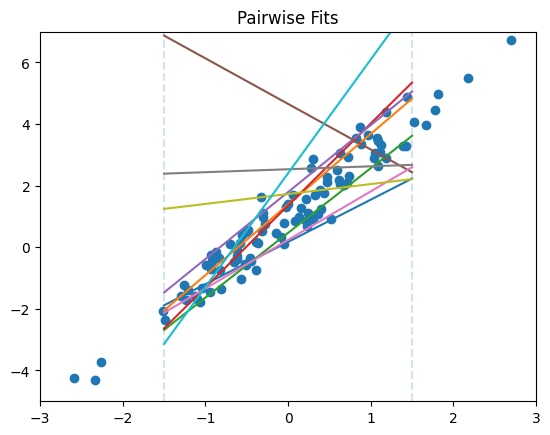

In [4]:
x_range, x_cuts = np.array([-3, 3]), np.array([-1.5, 1.5])

plt.title("Pairwise Fits")
plt.scatter(x, y)
plt.vlines(x_cuts, *f(x_range), linestyle='--', alpha=0.2) # cut lines
plt.xlim(*x_range)
plt.ylim(*f(x_range))

y_predictions = pairwise_predict(np.stack([x, y], axis=1), x_cuts=x_cuts)
for p in y_predictions[:10]:
    plt.plot(x_cuts, p) # pairwise fits


Each row in the resulting dataset contains the y values on the left and right side of each line.
Notice that adding one row to the input data results in the addition of up to one row in the output dataset.
Therefore it would be safe to say that the function is 1-stable:
adding one record results in the addition of up to one record in the output.

In [5]:
def make_pairwise_predict(x_cuts, runs: int = 1):
    return dp.t.make_user_transformation(
        # Outputs are Nx2 float numpy arrays.
        input_domain=dp.numpy.array2_domain(num_columns=2, T=float),
        # Neighboring input datasets differ by addition/removal of rows.
        input_metric=dp.symmetric_distance(),
        # Outputs are Nx2 float numpy arrays, but are half as long.
        output_domain=dp.numpy.array2_domain(num_columns=2, T=float),
        # Neighboring output datasets also differ by additions/removals.
        output_metric=dp.symmetric_distance(),
        # Apply the function `runs` times.
        function=lambda x: np.vstack(
            [pairwise_predict(x, x_cuts) for _ in range(runs)]
        ),
        # Each execution of pairwise predict contributes b_in records.
        stability_map=lambda b_in: b_in * runs,
    )

The parameter `runs` controls how many times randomized pairwise predictions are computed. 
The default is 1. Increasing `runs` can improve the robustness and accuracy of the results; 
however, it can also increase computational cost and amount of noise needed later in the algorithm. 

### 2. Measurement: DP Medians

Now we want to estimate the median of each column. 
We'll start with a 1-stable transformation that retrieves a column from the data.

In [6]:
def make_select_column(j):
    return dp.t.make_user_transformation(
        input_domain=dp.numpy.array2_domain(num_columns=2, T=float),
        input_metric=dp.symmetric_distance(),
        output_domain=dp.vector_domain(dp.atom_domain(T=float)),
        output_metric=dp.symmetric_distance(),
        function=lambda x: x[:, j],
        stability_map=lambda b_in: b_in)


We then use the quantile mechanism and composition combinators from OpenDP 
to build a new mechanism that estimates the differentially private medians of each column.

In [7]:
def make_private_percentile_medians(output_measure, y_bounds, scale):
    # this median mechanism favors candidates closest to the true median
    m_median = dp.m.then_private_quantile(
        output_measure,
        # 100 evenly spaced points between y_bounds
        candidates=np.linspace(*y_bounds, 100),
        alpha=0.5,
        scale=scale,
    )
    # apply the median mechanism to the 25th and 75th percentile columns
    return dp.c.make_composition([
        make_select_column(0) >> dp.t.then_drop_null() >> m_median,
        make_select_column(1) >> dp.t.then_drop_null() >> m_median,
    ])

### 3. Measurement: Thiel-Sen Estimator

We now put everything together, by chaining the previous steps with a postprocessor that transforms the percentile medians into regression coefficients.

In [8]:
def make_private_theil_sen(output_measure, x_bounds, y_bounds, scale, runs=1):
    # x_cuts are the 25th and 75th percentiles of x_bounds. 
    # We'll predict y's at these x_cuts.
    x_cuts = x_bounds[0] + (x_bounds[1] - x_bounds[0]) * np.array([0.25, 0.75])

    # we want coefficients, not y values! 
    # Luckily y values are related to coefficients via a linear system
    P_inv = np.linalg.inv(np.vstack([x_cuts, np.ones_like(x_cuts)]).T)

    return (
        # pairwise_predict will return a 2xN array of y values at the x_cuts.
        make_pairwise_predict(x_cuts, runs)
        # privately select median y values for each x_cut
        >> make_private_percentile_medians(output_measure, y_bounds, scale)
        # transform median y values to coefficients (slope and intercept)
        >> (lambda ys: P_inv @ ys)
    )

## Creating and Applying the Mechanism to Synthetic Data

Now apply the differentially private mechanism to a dataset. First, define an instance of the mechanism. 

In [9]:
x_bounds = -3, 3
y_bounds = -10, 10
meas = make_private_theil_sen(dp.max_divergence(), x_bounds, y_bounds, scale=1.0)

The mechanism satisfies $\epsilon = 1$, because each quantile mechanism recalibrates the scale to satisfy $\epsilon = 0.5$.

In [10]:
meas.map(1)

2.0

Finally, pass the data to the mechanism to release the differentially private coefficients.
We'll reuse the data from the earlier demonstration, where $y \approx 2 \cdot x + 1$.

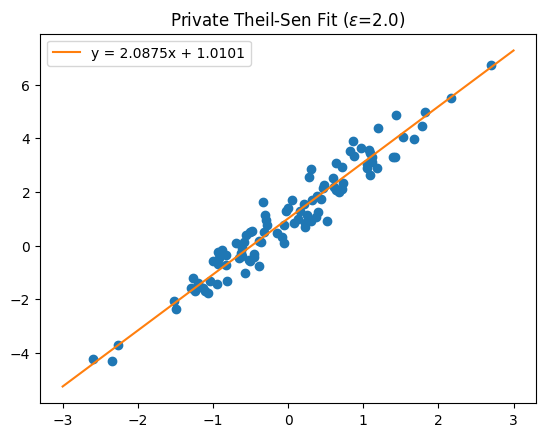

In [11]:
slope, intercept = meas(np.stack([x, y], axis=1))
y_fit = slope * np.array(x_bounds) + intercept
label = f'y = {slope:.4f}x + {intercept:.4f}'
plt.scatter(x, y)
plt.plot(x_bounds, y_fit, color="tab:orange", label=label)
plt.title(f"Private Theil-Sen Fit ($\\epsilon$={meas.map(1)})")
plt.legend();


The DP regression results align well with the underlying synthetic data.

The DP regression pipeline is a powerful method to extract valuable information while preserving individual privacy. The methods used in this tutorial can serve as the foundation of your data science workflow and further regressions. 